In [179]:
import nibabel as nb
import pandas
from nipype.interfaces import fsl

In [180]:
mni = nb.load(fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz'))

# Cue-related

## Left STN

In [181]:
zstats_thr = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_thresholded_zstats_file/_contrast_9_mask_STh_L/_threshold_2.6/_grf_cluster0/zstat1_threshold.nii.gz')

zstats_thr = np.ma.masked_equal(zstats_thr.get_data(), 0)

In [182]:
sns.set_context('poster')

x    95.166667
y    86.000000
z    53.500000
dtype: float64
x    38.333333
y    94.500000
z    57.500000
dtype: float64


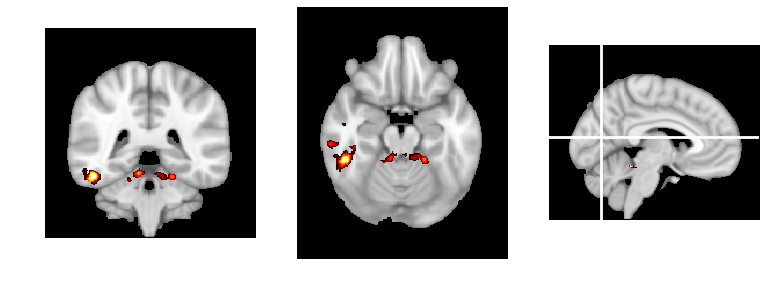

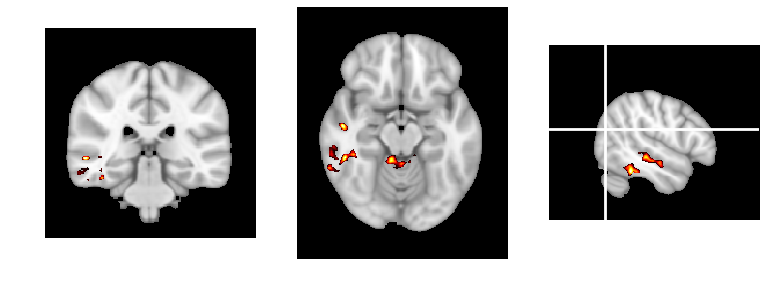

In [183]:
df = pandas.read_csv('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_localmax_txt_file/_contrast_9_mask_STh_L/_threshold_2.6/_grf_cluster0/zstat1_localmax.txt', sep='\t')

n_clusters = df['Cluster Index'].unique()


for (g, d) in df.groupby(['Cluster Index']):
    
    plt.figure()
    com = d.mean()[['x', 'y', 'z']]
    print com
    
    plt.subplot(131)
    plt.imshow(mni.get_data()[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mni.get_data()[..., int(com['z'])].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[..., int(com['z'])].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(mni.get_data()[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')    
    plt.axhline(com['y'], c='w', ls='-')
    plt.axvline(com['z'], c='w', ls='-')    
    
    plt.axis('off')    

In [184]:
cluster_indices = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/cluster_indices/_contrast_9_mask_STh_L/_threshold_2.6/_grf_cluster0/zstat1_index.nii.gz').get_data()

In [185]:
import glob

In [186]:
results = []

for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C']:
    for subject_id1 in np.arange(19):
        cope = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/transformed_copes/_contrast_9_mask_{mask}/_transformer{subject_id1}/cope1_trans.nii.gz'.format(**locals())).get_data()
        for cluster in df['Cluster Index'].unique():
            contrast = cope[cluster_indices == cluster].mean()
            
            results.append({'subject_id':subject_id1+1,
                            'mask':mask,
                            'cluster':cluster,
                            'contrast':contrast})

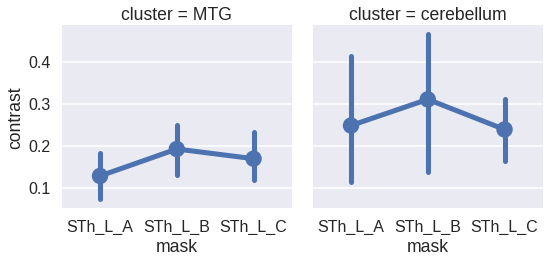

In [187]:
results = pandas.DataFrame(results)
results['cluster'] = results.cluster.map({1:'cerebellum', 2:'MTG'})
results['subject_id'] = results['subject_id'].astype('category')
sns.factorplot('mask', 'contrast', data=results, col='cluster')

In [188]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [189]:
for cluster, d in results.groupby('cluster'):
    print '**** %s ****' % cluster
    
    %R -i d
    %R print(summary(aov(contrast ~ mask + Error(subject_id/mask), d)))
    %R library(BayesFactor)
    %R bf = anovaBF(contrast ~ mask + subject_id, data=d, whichRandom="subject_id")
    %R print(bf)

**** MTG ****



Error: subject_id
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 18 0.5854 0.03252               

Error: subject_id:mask
          Df Sum Sq  Mean Sq F value Pr(>F)
mask       2 0.0401 0.020068   2.053  0.143
Residuals 36 0.3518 0.009772               


  |======================================================================| 100%


Bayes factor analysis
--------------
[1] mask + subject_id : 0.6133186 ±0.63%

Against denominator:
  contrast ~ subject_id 
---
Bayes factor type: BFlinearModel, JZS



**** cerebellum ****



Error: subject_id
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 18  2.924  0.1624               

Error: subject_id:mask
          Df Sum Sq Mean Sq F value Pr(>F)
mask       2 0.0576 0.02880    0.41  0.667
Residuals 36 2.5288 0.07024               


  |======================================================================| 100%


Bayes factor analysis
--------------
[1] mask + subject_id : 0.1917471 ±2.02%

Against denominator:
  contrast ~ subject_id 
---
Bayes factor type: BFlinearModel, JZS



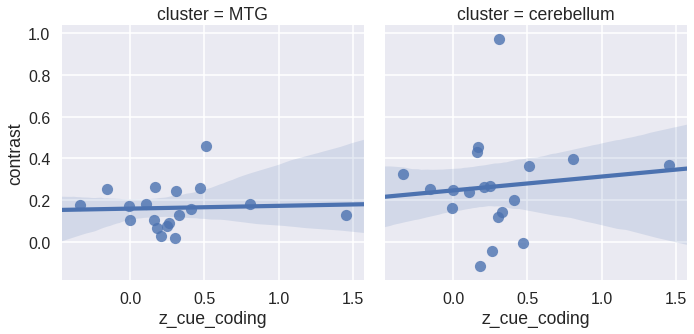

In [190]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = results.groupby(['subject_id', 'cluster'], as_index=False).mean().set_index('subject_id')
tmp = shifts.merge(tmp, left_index=True, right_index=True)

sns.lmplot('z_cue_coding', 'contrast', data=tmp, col='cluster')

In [191]:
for mask, t in tmp.groupby(['cluster']):
    print mask, sp.stats.pearsonr(t['z_cue_coding'], t['contrast'])
    
    %R -i t
    %R bf = lmBF(z_cue_coding ~ contrast, t)
    %R print(bf)

MTG (0.048554189688187921, 0.84352217117410411)


Bayes factor analysis
--------------
[1] contrast : 0.4100254 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



cerebellum (0.1082072368976715, 0.6592548078766276)


Bayes factor analysis
--------------
[1] contrast : 0.4339124 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



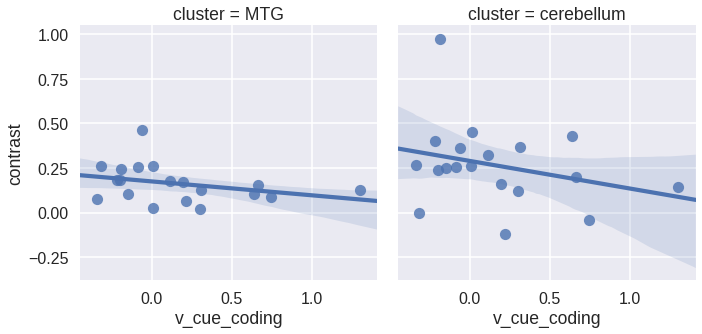

In [192]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = results.groupby(['subject_id', 'cluster'], as_index=False).mean().set_index('subject_id')
tmp = shifts.merge(tmp, left_index=True, right_index=True)

sns.lmplot('v_cue_coding', 'contrast', data=tmp, col='cluster')

In [193]:
for mask, t in tmp.groupby(['cluster']):
    print mask, sp.stats.pearsonr(t['z_cue_coding'], t['contrast'])
    
    %R -i t
    %R bf = lmBF(v_cue_coding ~ contrast, t)
    %R print(bf)

MTG (0.048554189688187921, 0.84352217117410411)


Bayes factor analysis
--------------
[1] contrast : 0.7794204 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



cerebellum (0.1082072368976715, 0.6592548078766276)


Bayes factor analysis
--------------
[1] contrast : 0.6745894 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



## Right STN

In [194]:
zstats_thr = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_thresholded_zstats_file/_contrast_9_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_threshold.nii.gz')
zstats_thr = np.ma.masked_equal(zstats_thr.get_data(), 0)

x     41.333333
y    116.000000
z     62.500000
dtype: float64
x    140.000000
y     93.166667
z     49.166667
dtype: float64


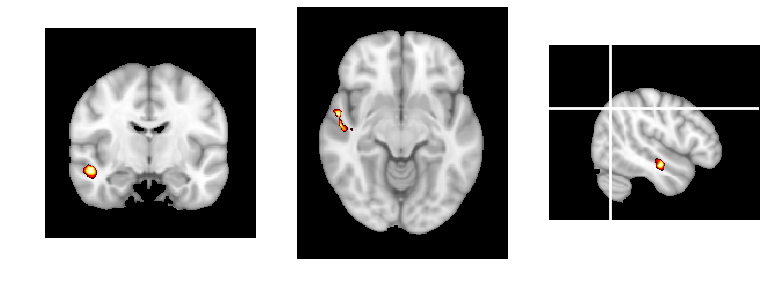

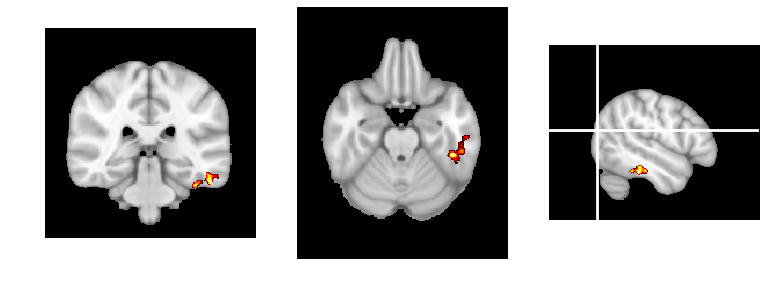

In [195]:
df = pandas.read_csv('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_localmax_txt_file/_contrast_9_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_localmax.txt', sep='\t')
n_clusters = df['Cluster Index'].unique()


for (g, d) in df.groupby(['Cluster Index']):
    
    plt.figure()
    com = d.mean()[['x', 'y', 'z']]
    print com
    
    plt.subplot(131)
    plt.imshow(mni.get_data()[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mni.get_data()[..., int(com['z'])].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[..., int(com['z'])].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(mni.get_data()[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')    
    plt.axhline(com['y'], c='w', ls='-')
    plt.axvline(com['z'], c='w', ls='-')    
    
    plt.axis('off')    

In [196]:
cluster_indices = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/cluster_indices/_contrast_9_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_index.nii.gz').get_data()

In [197]:
results = []

for mask in ['STh_R_A', 'STh_R_B', 'STh_R_C']:
    for subject_id1 in np.arange(19):
        print subject_id1
        cope = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/transformed_copes/_contrast_9_mask_{mask}/_transformer{subject_id1}/cope1_trans.nii.gz'.format(**locals())).get_data()
        for cluster in df['Cluster Index'].unique():
            contrast = cope[cluster_indices == cluster].mean()
            
            results.append({'subject_id':subject_id1+1,
                            'mask':mask,
                            'cluster':cluster,
                            'contrast':contrast})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


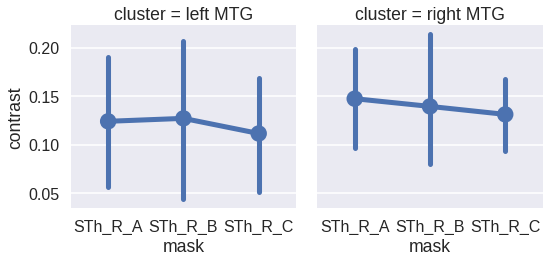

In [198]:
results = pandas.DataFrame(results)
results['cluster'] = results.cluster.map({1:'right MTG', 2:'left MTG'})
results['subject_id'] = results['subject_id'].astype('category')
sns.factorplot('mask', 'contrast', data=results, col='cluster')

In [199]:
for cluster, d in results.groupby('cluster'):
    print '**** %s ****' % cluster
    
    %R -i d
    %R print(summary(aov(contrast ~ mask + Error(subject_id/mask), d)))
    %R library(BayesFactor)
    %R bf = anovaBF(contrast ~ mask + subject_id, data=d, whichRandom="subject_id")
    %R print(bf)

**** left MTG ****



Error: subject_id
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 18 0.7433 0.04129               

Error: subject_id:mask
          Df Sum Sq  Mean Sq F value Pr(>F)
mask       2 0.0026 0.001299   0.079  0.925
Residuals 36 0.5955 0.016542               


  |======================================================================| 100%


Bayes factor analysis
--------------
[1] mask + subject_id : 0.1468995 ±0.85%

Against denominator:
  contrast ~ subject_id 
---
Bayes factor type: BFlinearModel, JZS



**** right MTG ****



Error: subject_id
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 18 0.3981 0.02211               

Error: subject_id:mask
          Df Sum Sq Mean Sq F value Pr(>F)
mask       2 0.0025 0.00124   0.106    0.9
Residuals 36 0.4207 0.01168               


  |======================================================================| 100%


Bayes factor analysis
--------------
[1] mask + subject_id : 0.1532376 ±1.1%

Against denominator:
  contrast ~ subject_id 
---
Bayes factor type: BFlinearModel, JZS



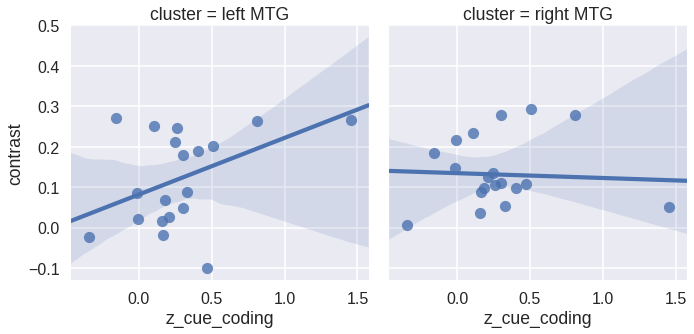

In [200]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = results.groupby(['subject_id', 'cluster'], as_index=False).mean().set_index('subject_id')
tmp = shifts.merge(tmp, left_index=True, right_index=True)

sns.lmplot('z_cue_coding', 'contrast', data=tmp, col='cluster', robust=True)

In [201]:
for mask, t in tmp.groupby(['cluster']):
    print mask, sp.stats.pearsonr(t['z_cue_coding'], t['contrast'])
    
    %R -i t
    %R bf = lmBF(z_cue_coding ~ contrast, t)
    %R print(bf)

left MTG (0.38210296856274145, 0.10643461879532845)


Bayes factor analysis
--------------
[1] contrast : 1.065559 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



right MTG (0.06957154506590596, 0.77716889748218265)


Bayes factor analysis
--------------
[1] contrast : 0.416208 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



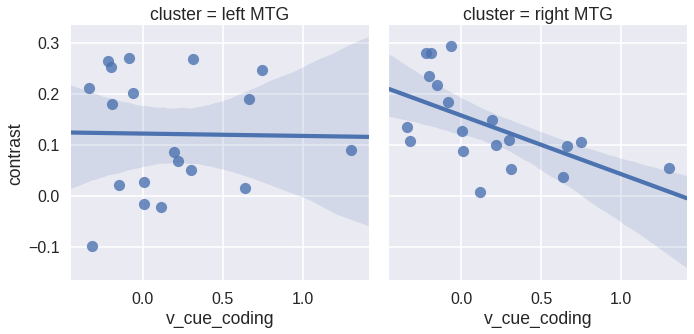

In [202]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = results.groupby(['subject_id', 'cluster'], as_index=False).mean().set_index('subject_id')
tmp = shifts.merge(tmp, left_index=True, right_index=True)

sns.lmplot('v_cue_coding', 'contrast', data=tmp, col='cluster')

In [204]:
for mask, t in tmp.groupby(['cluster']):
    print mask, sp.stats.pearsonr(t['v_cue_coding'], t['contrast'])
    
    %R -i t
    %R bf = lmBF(v_cue_coding ~ contrast, t)
    %R print(bf)

left MTG (-0.016679908888808541, 0.94596524747917177)


Bayes factor analysis
--------------
[1] contrast : NA ±NA%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



right MTG (-0.57343253665589045, 0.010263524845992562)


Bayes factor analysis
--------------
[1] contrast : 5.098337 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



# Stimulus-related

In [167]:
from IPython.display import display

In [168]:
for contrast in np.arange(9, 17):
    print '**** %s ****' % contrast
    df = pandas.read_csv('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_localmax_txt_file/_contrast_%s_mask_STh_L/_threshold_2.3/_grf_cluster0/zstat1_localmax.txt' % contrast, sep='\t')
    display(df)

**** 9 ****


,Cluster Index,Value,x,y,z,Unnamed: 5
0,3,4.01,38,84,50,NaN
1,3,3.99,41,86,53,NaN
2,3,3.74,40,99,64,NaN
3,3,3.61,39,113,59,NaN
4,3,3.60,39,90,50,NaN
5,3,3.60,33,95,69,NaN
6,2,3.50,80,85,55,NaN
7,2,3.47,113,74,56,NaN
8,2,3.41,110,86,52,NaN
9,2,3.36,101,88,50,NaN


**** 10 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 11 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 12 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 13 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 14 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 15 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 16 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


In [169]:
for contrast in np.arange(9, 17):
    print '**** %s ****' % contrast
    df = pandas.read_csv('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_localmax_txt_file/_contrast_%s_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_localmax.txt' % contrast, sep='\t')
    display(df)

**** 9 ****


,Cluster Index,Value,x,y,z,Unnamed: 5
0,2,3.90,134,89,50,NaN
1,2,3.60,153,79,54,NaN
2,2,3.42,142,92,48,NaN
3,2,3.11,142,98,52,NaN
4,2,3.05,125,97,42,NaN
5,2,3.02,144,104,49,NaN
6,1,4.25,39,115,56,NaN
7,1,3.72,34,129,65,NaN
8,1,3.33,35,125,62,NaN
9,1,3.16,45,110,65,NaN


**** 10 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 11 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 12 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 13 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 14 ****


,Cluster Index,Value,x,y,z,Unnamed: 5
0,2,3.79,82,115,67,NaN
1,2,3.56,84,103,68,NaN
2,2,3.50,82,107,68,NaN
3,2,3.49,82,109,68,NaN
4,2,3.43,96,101,68,NaN
5,2,3.36,98,114,66,NaN
6,1,3.66,58,62,48,NaN
7,1,3.66,60,61,48,NaN
8,1,3.64,57,64,47,NaN
9,1,3.47,64,59,54,NaN


**** 15 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


**** 16 ****


,Cluster Index,Value,x,y,z,Unnamed: 5


### Contrast 14: 'easy rdm (correct) * nucleus signal > easy rdm (error) * nucleus signal

In [170]:
zstats_thr = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_thresholded_zstats_file/_contrast_14_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_threshold.nii.gz')

zstats_thr = np.ma.masked_equal(zstats_thr.get_data(), 0)

x    60.833333
y    57.000000
z    53.500000
dtype: float64
x     87.333333
y    108.166667
z     67.500000
dtype: float64


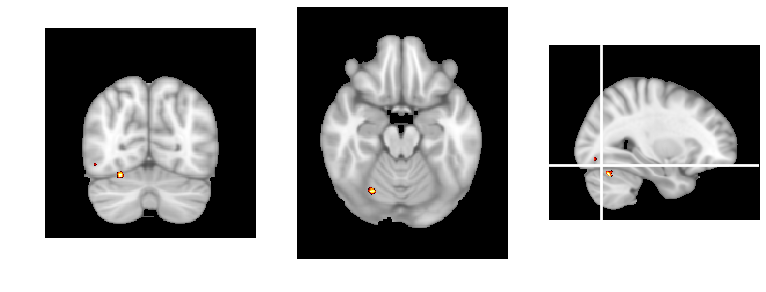

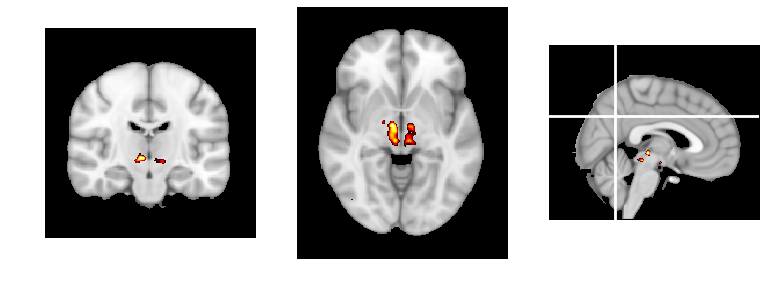

In [171]:
df = pandas.read_csv('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/grf_localmax_txt_file/_contrast_14_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_localmax.txt', sep='\t')

n_clusters = df['Cluster Index'].unique()


for (g, d) in df.groupby(['Cluster Index']):
    
    plt.figure()
    com = d.mean()[['x', 'y', 'z']]
    print com
    
    plt.subplot(131)
    plt.imshow(mni.get_data()[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[:, int(com['y']), :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mni.get_data()[..., int(com['z'])].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[..., int(com['z'])].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(mni.get_data()[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(zstats_thr[int(com['x']), :, :].T, origin='lower', cmap=plt.cm.hot, interpolation='nearest')    
    plt.axhline(com['y'], c='w', ls='-')
    plt.axvline(com['z'], c='w', ls='-')    
    
    plt.axis('off')    

In [172]:
cluster_indices = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/cluster_indices/_contrast_14_mask_STh_R/_threshold_2.6/_grf_cluster0/zstat1_index.nii.gz').get_data()

In [173]:
results = []

for mask in ['STh_R_A', 'STh_R_B', 'STh_R_C']:
    for subject_id1 in np.arange(19):
        print subject_id1
        cope = nb.load('/home/gdholla1/projects/bias/data/derivatives/glm_fits_level3/transformed_copes/_contrast_14_mask_{mask}/_transformer{subject_id1}/cope1_trans.nii.gz'.format(**locals())).get_data()
        for cluster in df['Cluster Index'].unique():
            contrast = cope[cluster_indices == cluster].mean()
            
            results.append({'subject_id':subject_id1+1,
                            'mask':mask,
                            'cluster':cluster,
                            'contrast':contrast})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


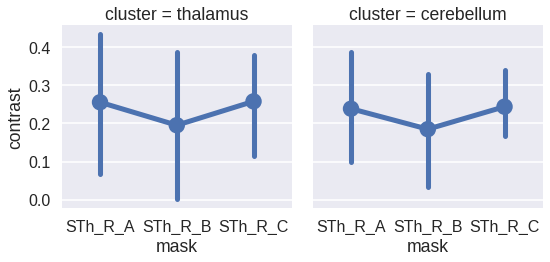

In [174]:
results = pandas.DataFrame(results)
results['cluster'] = results.cluster.map({1:'cerebellum', 2:'thalamus'})
results['subject_id'] = results['subject_id'].astype('category')
sns.factorplot('mask', 'contrast', data=results, col='cluster')

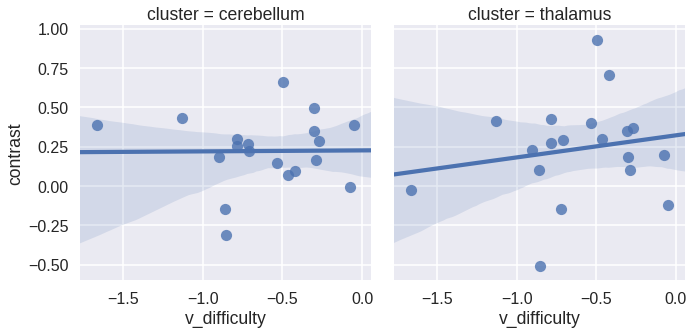

In [177]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = results.groupby(['subject_id', 'cluster'], as_index=False).mean().set_index('subject_id')
tmp = shifts.merge(tmp, left_index=True, right_index=True)

sns.lmplot('v_difficulty', 'contrast', data=tmp, col='cluster')

In [178]:
for mask, t in tmp.groupby(['cluster']):
    print mask, sp.stats.pearsonr(t['z_cue_coding'], t['contrast'])
    
    %R -i t
    %R bf = lmBF(v_difficulty ~ contrast, t)
    %R print(bf)

cerebellum (0.17295676043866767, 0.47889317265054865)


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in integrate(integrand.regression, lower = 0, upper = Inf, N = N,  : 
  non-finite function value

  warnings.warn(x, RRuntimeWarning)


Bayes factor analysis
--------------
[1] contrast : NA ±NA%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



thalamus (-0.017376341207711581, 0.94371248343982772)


Bayes factor analysis
--------------
[1] contrast : 0.4881158 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

